# Federated Learning Implementation with tensorflow



In [1]:
# """
# Adult Dataset Salary Prediction 
# This is part of a study to investigate Differetinal privacy in Machine learning, Naturally we wish to compare it with federated learning.



# Refrences:

# [1] Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018
# [2] Communication-Efficient Learning of Deep Networks from Decentralized Data, H. Brendan McMahan et al, arXiv:1602.05629v3 [cs.LG] 28 Feb 2017

# """

In [2]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix,f1_score
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History

import pandas as pd



C:\Users\riash\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
### Train/Test Data seperation

file_out = pd.read_csv('Data/adult_processed.csv')
cols = []
for i in list(file_out.columns):
    if  i != 'income':
        cols.append(i)

feature_set1 = pd.read_csv('Data/train.csv')
feature_set2 = pd.read_csv('Data/test.csv')

print(feature_set1['race_White'])
x = feature_set1[cols].copy().values
y = feature_set1[['income']].copy().values
        
sc = StandardScaler()
X_train = sc.fit_transform(x)
y_train = y

x2 = feature_set2[cols].copy().values
y2 = feature_set2[['income']].copy().values
        
X_test = sc.transform(x2)
y_test = y2


X_test.shape, y_test.shape 

0        1
1        1
2        1
3        1
4        1
        ..
39068    0
39069    1
39070    1
39071    1
39072    1
Name: race_White, Length: 39073, dtype: int64


((9768, 94), (9768, 1))

In [4]:
# Train/Test data based on  gender: 4 sets

# train

female_features =  feature_set1[feature_set1['gender_Female']==1]
x_female = female_features[cols].copy().values
y_female = female_features[['income']].copy().values

X_train_female = sc.fit_transform(x_female)
y_train_female = y_female

male_features = feature_set1[feature_set1['gender_Male']==1] 
x_male = male_features[cols].copy().values
y_male = male_features[['income']].copy().values

X_train_male = sc.fit_transform(x_male)
y_train_male = y_male

# test

female_features2 =  feature_set2[feature_set2['gender_Female']==1]
x_female2 = female_features2[cols].copy().values
y_female2 = female_features2[['income']].copy().values

X_test_female = sc.fit_transform(x_female2)
y_test_female = y_female2 

male_features2 = feature_set2[feature_set2['gender_Male']==1] 
x_male2 = male_features2[cols].copy().values
y_male2 = male_features2[['income']].copy().values

X_test_male = sc.fit_transform(x_male2)
y_test_male = y_male2


# checks
X_train.shape, X_train_female.shape, X_train_male.shape
# X_test.shape, X_test_female.shape, X_test_male.shape
# y_train.shape, y_train_female.shape, y_train_male.shape


((39073, 94), (12919, 94), (26154, 94))

In [5]:
female_features_above30 = female_features[female_features['age']>30]
x_female_age = female_features_above30[cols].copy().values
y_female_age = female_features_above30[['income']].copy().values

X_train_female_age = sc.fit_transform(x_female_age)
y_train_female_age = y_female_age

male_features_above30 = male_features[male_features['age']>30]
x_male_age = male_features_above30[cols].copy().values
y_male_age = male_features_above30[['income']].copy().values

X_train_male_age = sc.fit_transform(x_male_age)
y_train_male_age = y_male_age

# test

female_features_above30_2 =  female_features2[female_features2['age']>30]
x_female_age2 = female_features_above30_2[cols].copy().values
y_female_age2 = female_features_above30_2[['income']].copy().values

X_test_female_age = sc.fit_transform(x_female_age2)
y_test_female_age = y_female_age2 

male_features_above30_2 = male_features2[male_features2['age']>30]
x_male_age2 = male_features_above30_2[cols].copy().values
y_male_age2 = male_features_above30_2[['income']].copy().values

X_test_male_age = sc.fit_transform(x_male_age2)
y_test_male_age = y_male_age2


# checks
X_train.shape, X_train_female_age.shape, X_train_male_age.shape
# X_test.shape, X_test_female.shape, X_test_male.shape
# y_train.shape, y_train_female.shape, y_train_male.shape

((39073, 94), (7761, 94), (18606, 94))

In [6]:

def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
#     client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

#     iid
#     #randomize the data
#     data = list(zip(image_list, label_list))
#     random.shuffle(data)
    
   
    
#     non-iid //////////////////////////////////////
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

# LOGIC:
#    image_list length-->total data items
#    taking 50 images in each shard--> num_shards = image_list/41 gives 953 shards
#    num_shard = num_shards + 1 if(image_list%50 >0) 

    num_shards, num_imgs = 953, 41
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_clients)}
#     dict_users = [i for i in range(num_clients)]
#     idxs = np.arange(num_shards*num_imgs)
#     labels = dataset.train_labels.numpy()

    max_y = np.argmax(label_list, axis=-1)
#     image_list = np.argmax(image_list, axis=-1)
#     print(idxs.shape, label_list.shape)
    
#     idxs_labels = np.vstack((idxs, max_y))
#     idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
#     idxs = idxs_labels[0, :]

    min_shard = 1
    max_shard = 60  #953/15 = 63.53
    
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_clients)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)


    if sum(random_shard_size) > num_shards:

        for i in range(num_clients):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_clients):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)

    else:

        for i in range(num_clients):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[k]) == 0):
                    dict_users[k] = data[ind1: ind2]
                else:
                    dict_users[k] = np.concatenate(
                    (dict_users[k],data[ind1: ind2]),
                    axis=0)
                
    return dict_users

#   ////////////////////////////////////////////////////  
    #shard data and place at each client
#     size = len(data)//num_clients
#     shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

#     #number of clients must equal number of shards
#     assert(len(shards) == len(client_names))

#     print(len(image_list))
#     for i in range(len(client_names)):
#         print(client_names[i], len(shards[i]))
              
#     return {client_names[i] : shards[i] for i in range(len(client_names))} 


clients = create_clients(X_train, y_train, num_clients=15, initial='client')
# print(clients)

for i in range(len(clients.keys())):
        print(i, len(clients[i]))

print(type(clients))

0 3936
1 1558
2 3034
3 2870
4 3608
5 3116
6 1394
7 4182
8 4920
9 1312
10 2132
11 1886
12 738
13 3116
14 1271
<class 'dict'>


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
# gender split

dict_users = {i: np.array([]) for i in range(4)}
data_out = []

def create_hetero_clients( image_list, label_list, start_client = 0, num_clients=10, initial='clients'):
    
    selected_inds = []

    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]
    
    data_out = data
    
    num_shards, num_imgs = int(len(image_list)/30), 30
    idx_shard = [i for i in range(num_shards)]

    min_shard = 1
    max_shard = 60  #953/15 = 63.53
    
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=(num_clients-start_client))
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)


    if sum(random_shard_size) > num_shards:
        
        for i in range(start_client, num_clients):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(start_client, num_clients):
            if len(idx_shard) == 0:
                continue
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

    else:

        for i in range(start_client, num_clients):
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
#             shard_size = random_shard_size[int(i/len(random_shard_size)) - 1]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[k]) == 0):
                    dict_users[k] = data[ind1: ind2]
                else:
                    dict_users[k] = np.concatenate(
                    (dict_users[k],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])
                
                
    return dict_users, selected_inds, data_out



In [8]:
def get_hetero_clients():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    x_female = female_features[cols].copy().values
    y_female = female_features[['income']].copy().values

    X_train_female = sc.fit_transform(x_female)
    y_train_female = y_female

    male_features = feature_set1[feature_set1['gender_Male']==1] 
    x_male = male_features[cols].copy().values
    y_male = male_features[['income']].copy().values

    X_train_male = sc.fit_transform(x_male)
    y_train_male = y_male

    # test

    female_features2 =  feature_set2[feature_set2['gender_Female']==1]
    x_female2 = female_features2[cols].copy().values
    y_female2 = female_features2[['income']].copy().values

    X_test_female = sc.fit_transform(x_female2)
    y_test_female = y_female2 

    male_features2 = feature_set2[feature_set2['gender_Male']==1] 
    x_male2 = male_features2[cols].copy().values
    y_male2 = male_features2[['income']].copy().values

    X_test_male = sc.fit_transform(x_male2)
    y_test_male = y_male2

#     shuffling male and female datalists
#     print(X_train_male.shape)
    data = list(zip(X_train_male, y_train_male))
    random.shuffle(data)
    
    X_train_male, y_train_male = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(X_train_female, y_train_female))
    random.shuffle(data)
    
    X_train_female, y_train_female = list(zip(*data))[0], list(zip(*data))[1]
    
    
    
    # 1 all male
    clients, inds, data_out1 = create_hetero_clients(X_train_male[:5230], y_train_male[:5230], start_client = 0, num_clients=1, initial='client') 
    # 1 all female
    clients2, inds2, data_out2 = create_hetero_clients(X_train_female[:2584], y_train_female[:2584], start_client = 1, num_clients=2, initial='client')
    clients = {**clients, **clients2}

    used_x = []
    used_y = []
    used_data = []
  
    for i,j in list(inds):
        for x in range(i,j):
            used_data.insert(len(used_data)-1,(data_out1[x]))  
  
    for x in used_data:
        used_x.insert(len(used_x)-1,x[0])
        used_y.insert(len(used_y)-1,x[1])  
   
    used_data.clear()

    for i,j in list(inds2):
        for x in range(i,j):
            used_data.insert(len(used_data)-1,(data_out2[x]))  

    for x in used_data:
        used_x.insert(len(used_x)-1,x[0])
        used_y.insert(len(used_y)-1,x[1])  

    # 3 mix
    X_train_mix = np.setdiff1d(X_train, np.array(used_x))#53834, 64278
    y_train_mix = np.setdiff1d(y_train, np.array(used_y))

#     print(X_train_mix.shape, X_train.shape)
#     print(y_train_mix.shape, y_train.shape)

    clients3, inds3 , data_out= create_hetero_clients(X_train_mix, y_train_mix, start_client = 2, num_clients=5, initial='client')
    clients = {**clients, **clients3}
    
    return clients


In [9]:
def initializer():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    x_female = female_features[cols].copy().values
    y_female = female_features[['income']].copy().values

    X_train_female = sc.fit_transform(x_female)
    y_train_female = y_female

    male_features = feature_set1[feature_set1['gender_Male']==1] 
    x_male = male_features[cols].copy().values
    y_male = male_features[['income']].copy().values

    X_train_male = sc.fit_transform(x_male)
    y_train_male = y_male

    # test

    female_features2 =  feature_set2[feature_set2['gender_Female']==1]
    x_female2 = female_features2[cols].copy().values
    y_female2 = female_features2[['income']].copy().values

    X_test_female = sc.fit_transform(x_female2)
    y_test_female = y_female2 

    male_features2 = feature_set2[feature_set2['gender_Male']==1] 
    x_male2 = male_features2[cols].copy().values
    y_male2 = male_features2[['income']].copy().values

    X_test_male = sc.fit_transform(x_male2)
    y_test_male = y_male2
    
#   train-- with age
    female_features_above30 = female_features[female_features['age']>30]
    x_female_age = female_features_above30[cols].copy().values
    y_female_age = female_features_above30[['income']].copy().values

    X_train_female_age = sc.fit_transform(x_female_age)
    y_train_female_age = y_female_age

    male_features_above30 = male_features[male_features['age']>30]
    x_male_age = male_features_above30[cols].copy().values
    y_male_age = male_features_above30[['income']].copy().values

    X_train_male_age = sc.fit_transform(x_male_age)
    y_train_male_age = y_male_age

    # test

    female_features_above30_2 =  female_features2[female_features2['age']>30]
    x_female_age2 = female_features_above30_2[cols].copy().values
    y_female_age2 = female_features_above30_2[['income']].copy().values

    X_test_female_age = sc.fit_transform(x_female_age2)
    y_test_female_age = y_female_age2 

    male_features_above30_2 = male_features2[male_features2['age']>30]
    x_male_age2 = male_features_above30_2[cols].copy().values
    y_male_age2 = male_features_above30_2[['income']].copy().values

    X_test_male_age = sc.fit_transform(x_male_age2)
    y_test_male_age = y_male_age2
    
    return X_train_male_age, y_train_male_age,  X_train_female_age, y_train_female_age

In [10]:
def initializer_income():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    female_features_above30 = female_features[female_features['income']==1]
    x_female_age = female_features_above30[cols].copy().values
    y_female_age = female_features_above30[['income']].copy().values
    
    female_features_below = female_features[female_features['income']==0]
    x_female_less = female_features_below[cols].copy().values
    y_female_less = female_features_below[['income']].copy().values

    X_train_female_age = sc.fit_transform(x_female_age)
    y_train_female_age = y_female_age
    
    X_train_female_less = sc.fit_transform(x_female_less)
    y_train_female_less = y_female_less


    male_features = feature_set1[feature_set1['gender_Male']==1] 
    male_features_above30 = male_features[male_features['income']==1]
    x_male_age = male_features_above30[cols].copy().values
    y_male_age = male_features_above30[['income']].copy().values
    
    male_features_below = male_features[male_features['income']==0]
    x_male_less = male_features_below[cols].copy().values
    y_male_less = male_features_below[['income']].copy().values

    X_train_male_age = sc.fit_transform(x_male_age)
    y_train_male_age = y_male_age
    
    X_train_male_less = sc.fit_transform(x_male_less)
    y_train_male_less = y_male_less


    # test

    female_features2 =  feature_set2[feature_set2['gender_Female']==1]
    female_features_above30_2 =  female_features2[female_features2['income']==1]
    x_female_age2 = female_features_above30_2[cols].copy().values
    y_female_age2 = female_features_above30_2[['income']].copy().values

    X_test_female_age = sc.fit_transform(x_female_age2)
    y_test_female_age = y_female_age2 


    male_features2 = feature_set2[feature_set2['gender_Male']==1]
    male_features_above30_2 = male_features2[male_features2['income']==1]
    x_male_age2 = male_features_above30_2[cols].copy().values
    y_male_age2 = male_features_above30_2[['income']].copy().values

    X_test_male_age = sc.fit_transform(x_male_age2)
    y_test_male_age = y_male_age2

    
    return [X_train_male_age, y_train_male_age,  X_train_female_age, y_train_female_age, X_train_male_less, y_train_male_less,  X_train_female_less, y_train_female_less]

In [11]:
# def initializer_income_race_gender():
    
#     female_features =  feature_set1[feature_set1['gender_Female']==1]
#     female_features_above50 = female_features[female_features['income']==1]
#     female_features_above50_white = female_features_above50[female_features_above50['race_White']==1]
#     female_features_above50_black = female_features_above50[female_features_above50['race_Black']==1]
    
# #     white, female, >50k
#     x_female_white_more = female_features_above50_white[cols].copy().values
#     y_female_white_more = female_features_above50_white[['income']].copy().values
    
# #     black, female, >50k
#     x_female_black_more = female_features_above50_black[cols].copy().values
#     x_female_black_more = female_features_above50_black[['income']].copy().values
#     female_features_below = female_features[female_features['income']==0]
#     female_features_below_white = female_features_below[female_features_below['race_White']==1]
#     female_features_below_black = female_features_below[female_features_below['race_Black']==1]
    
#     x_female_less = female_features_below[cols].copy().values
#     y_female_less = female_features_below[['income']].copy().values

#     X_train_female_age = sc.fit_transform(x_female_age)
#     y_train_female_age = y_female_age
    
#     X_train_female_less = sc.fit_transform(x_female_less)
#     y_train_female_less = y_female_less


#     male_features = feature_set1[feature_set1['gender_Male']==1] 
#     male_features_above30 = male_features[male_features['income']==1]
#     x_male_age = male_features_above30[cols].copy().values
#     y_male_age = male_features_above30[['income']].copy().values
    
#     male_features_below = male_features[male_features['income']==0]
#     x_male_less = male_features_below[cols].copy().values
#     y_male_less = male_features_below[['income']].copy().values

#     X_train_male_age = sc.fit_transform(x_male_age)
#     y_train_male_age = y_male_age
    
#     X_train_male_less = sc.fit_transform(x_male_less)
#     y_train_male_less = y_male_less


#     # test

#     female_features2 =  feature_set2[feature_set2['gender_Female']==1]
#     female_features_above30_2 =  female_features2[female_features2['income']==1]
#     x_female_age2 = female_features_above30_2[cols].copy().values
#     y_female_age2 = female_features_above30_2[['income']].copy().values

#     X_test_female_age = sc.fit_transform(x_female_age2)
#     y_test_female_age = y_female_age2 


#     male_features2 = feature_set2[feature_set2['gender_Male']==1]
#     male_features_above30_2 = male_features2[male_features2['income']==1]
#     x_male_age2 = male_features_above30_2[cols].copy().values
#     y_male_age2 = male_features_above30_2[['income']].copy().values

#     X_test_male_age = sc.fit_transform(x_male_age2)
#     y_test_male_age = y_male_age2

    
#     return [X_train_male_age, y_train_male_age,  X_train_female_age, y_train_female_age, X_train_male_less, y_train_male_less,  X_train_female_less, y_train_female_less]

In [12]:
def get_hetero_clients_gender_age(train_sets):
    
    data = list(zip(train_sets[0], train_sets[1]))
    random.shuffle(data)
    
#     print(type(train_sets), type(train_sets[0]),type(list(list(zip(*data))[0]) ), type(data))
    
    train_sets[0] = list(list(zip(*data))[0])
    train_sets[1] = list(list(zip(*data))[1])
    data.clear()
    
    data = list(zip(train_sets[2], train_sets[3]))
    random.shuffle(data)
    
    train_sets[2], train_sets[3] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[4], train_sets[5]))
    random.shuffle(data)
    
    train_sets[4], train_sets[5] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[6], train_sets[7]))
    random.shuffle(data)
    
    train_sets[6], train_sets[7] = list(zip(*data))[0], list(zip(*data))[1]
    
    
    # 1 all male
    clients, inds, data_out1 = create_hetero_clients(train_sets[0][:3721], train_sets[1][:3721], start_client = 0, num_clients=1, initial='client') 
    # 1 all female
    clients2, inds2, data_out2 = create_hetero_clients(train_sets[2][:1552], train_sets[3][:1552], start_client = 1, num_clients=2, initial='client')
    clients = {**clients, **clients2}
    
    clients3, inds3, data_out3 = create_hetero_clients(train_sets[4][:1552], train_sets[5][:1552], start_client = 2, num_clients=3, initial='client')
    clients = {**clients, **clients3}
    
    clients4, inds4, data_out4 = create_hetero_clients(train_sets[6][:1552], train_sets[7][:1552], start_client = 3, num_clients=4, initial='client')
    clients = {**clients, **clients4}

#     used_x = []
#     used_y = []
#     used_data = []
  
#     for i,j in list(inds):
#         for x in range(i,j):
#             used_data.insert(len(used_data)-1,(data_out1[x]))  
  
#     for x in used_data:
#         used_x.insert(len(used_x)-1,x[0])
#         used_y.insert(len(used_y)-1,x[1])  
   
#     used_data.clear()

#     for i,j in list(inds2):
#         for x in range(i,j):
#             used_data.insert(len(used_data)-1,(data_out2[x]))  

#     for x in used_data:
#         used_x.insert(len(used_x)-1,x[0])
#         used_y.insert(len(used_y)-1,x[1])  

#     # 3 mix
#     X_train_mix = np.setdiff1d(X_train, np.array(used_x))#53834, 64278
#     y_train_mix = np.setdiff1d(y_train, np.array(used_y))

#     print(X_train_mix.shape, X_train.shape)
#     print(type(X_train_mix), type(X_train))
#     print(type(data_out))
#     print(y_train_mix.shape, y_train.shape)

#     clients3, inds3 , data_out= create_hetero_clients(X_train, y_train, start_client = 2, num_clients=5, initial='client')
#     clients = {**clients, **clients3}
    
    return clients


In [13]:
# take bs = 128 for 5 clients and 10 rounds
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    data = []
    label = []
    for x in data_shard:
        data.append(x[0])
        label.append(x[1])
    #seperate shard into data and labels lists
#     data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
#     print(data[0], label[0])
    return dataset.shuffle(len(label)).batch(bs)

In [14]:

#process and batch the training data for each client
def batch_clients(clients):
    clients_batched = dict()
    for (client_name, data) in clients.items():
#         print("data ",data)
        clients_batched[client_name] = batch_data(data)

    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
#     test_batched
    return clients_batched, test_batched


In [15]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes=2 , learning_rate = 0.001, metric = "accuracy"):

        model = Sequential()
        
        model.add(Dense(128, input_shape = (shape,)))
#         model.add(Dense(128, Activation("relu")))
#         model.add(Dense(64, Activation("relu")))
#         model.add(Dense(32, Activation("relu")))
#         model.add(Dense(1))
        
        model.add(Dense(128, Activation("tanh")))
        model.add(Dense(64, Activation("tanh")))
        model.add(Dense(32, Activation("tanh")))
        model.add(Dense(1,Activation('sigmoid')))
        


        return model

In [16]:
lr = 0.005
comms_round = 10
loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']

optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )     



In [17]:


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
#     print(len(scaled_weight_list))
    for grad_list_tuple in zip(*scaled_weight_list):
#         print(len(grad_list_tuple))
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    
#     cce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    logits = model.predict(X_test)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    acc = score[1] ; loss = score[0]
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))

    return acc, loss

In [18]:

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X_train.shape[1] ,classes=2)
global_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
# clients_batched, test_batched = batch_clients(clients)
# client_names= list(clients_batched.keys())
client_names = [0, 1, 2, 3,4]
# print(client_names, "asugdefbh")
# print(clients_batched)

client_loss = {i: np.array([]) for i in range(len(client_names))}
client_frequency = {i: np.array([]) for i in range(len(client_names))}
train_sets = initializer_income()
# print(len(train_sets))
#commence global training loop
for comm_round in range(comms_round):
            
#     clients = create_clients(X_train, y_train, num_clients=15, initial='client')
#     clients = get_hetero_clients()
    clients = get_hetero_clients_gender_age(list(train_sets) )
#     print("cllients: ", clients)
    clients_batched, test_batched = batch_clients(clients)
        
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
#     print(client_names)
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X_train.shape[1],classes=2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        history = local_model.fit(clients_batched[client], epochs=1, verbose=1)
        
#         get client acc, loss
#         print(client)
        if(len(client_loss[client])== 0):
            client_loss[client] = [history.history['loss'][0]]
            client_frequency[client] = [len(clients_batched[client])]
        
        else:
            client_loss[client] = np.append(client_loss[client], (history.history['loss'][0]))
            client_frequency[client] = np.append(client_frequency[client], len(clients_batched[client]))
        
        print("client", client, "loss -->" ,client_loss[client], "freq->", client_frequency[client])
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

#     test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)



<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 2ms/step - loss: 0.6019 - binary_accuracy: 0.7149
client 1 loss --> [0.6018638014793396] freq-> [23]
24/24 [==============================] - 0s 2ms/step - loss: 0.6394 - binary_accuracy: 0.6438
client 2 loss --> [0.639370322227478] freq-> [24]
59/59 [==============================] - 0s 2ms/step - loss: 0.4676 - binary_accuracy: 0.8538
client 0 loss --> [0.46760597825050354] freq-> [59]
24/24 [==============================] - 0s 2ms/step - loss: 0.6486 - binary_accuracy: 0.6346
client 3 loss --> [0.6485884785652161] freq-> [24]
comm_round: 0 | global_acc: 31.910% | global_loss: 0.8506436944007874
48/48 [==============================] - 0s 2ms/step - loss: 0.6638 - binary_accuracy: 0.6065
client 2 loss --> [0.63937032 0.66379863] freq-> [24 48]
117/117 [==============================] - 0s 2ms/step - loss: 0.2931 - binary_accuracy: 0.9574
client 0 loss --> [0.46760598 0.29313833] freq-> [ 59 117]
48/48 [==============================] - 0s 

240/240 [==============================] - 0s 2ms/step - loss: 0.3196 - binary_accuracy: 0.8622
client 2 loss --> [0.63937032 0.66379863 0.68756843 0.67364216 0.59808981 0.55789202
 0.4846977  0.39161021 0.35825101 0.31958067] freq-> [ 24  48  72  96 120 144 168 192 216 240]
582/582 [==============================] - 1s 2ms/step - loss: 0.0587 - binary_accuracy: 0.9992
client 0 loss --> [0.46760598 0.29313833 0.19944715 0.14965278 0.12055031 0.09869111
 0.08096817 0.07195795 0.06474853 0.05870034] freq-> [ 59 117 175 233 291 349 407 465 524 582]
comm_round: 9 | global_acc: 37.766% | global_loss: 1.3119407892227173


client_ 0  loss:  [5.93865416 5.13758057 5.17266814 ... 7.34843944 6.53012386 5.02555234] freq:  [ 59 117 175 233 291 349 407 465 524 582]
Shape: 0.9971060021175812
Location: 5.0000961200979726
Scale: 0.9949372877534306


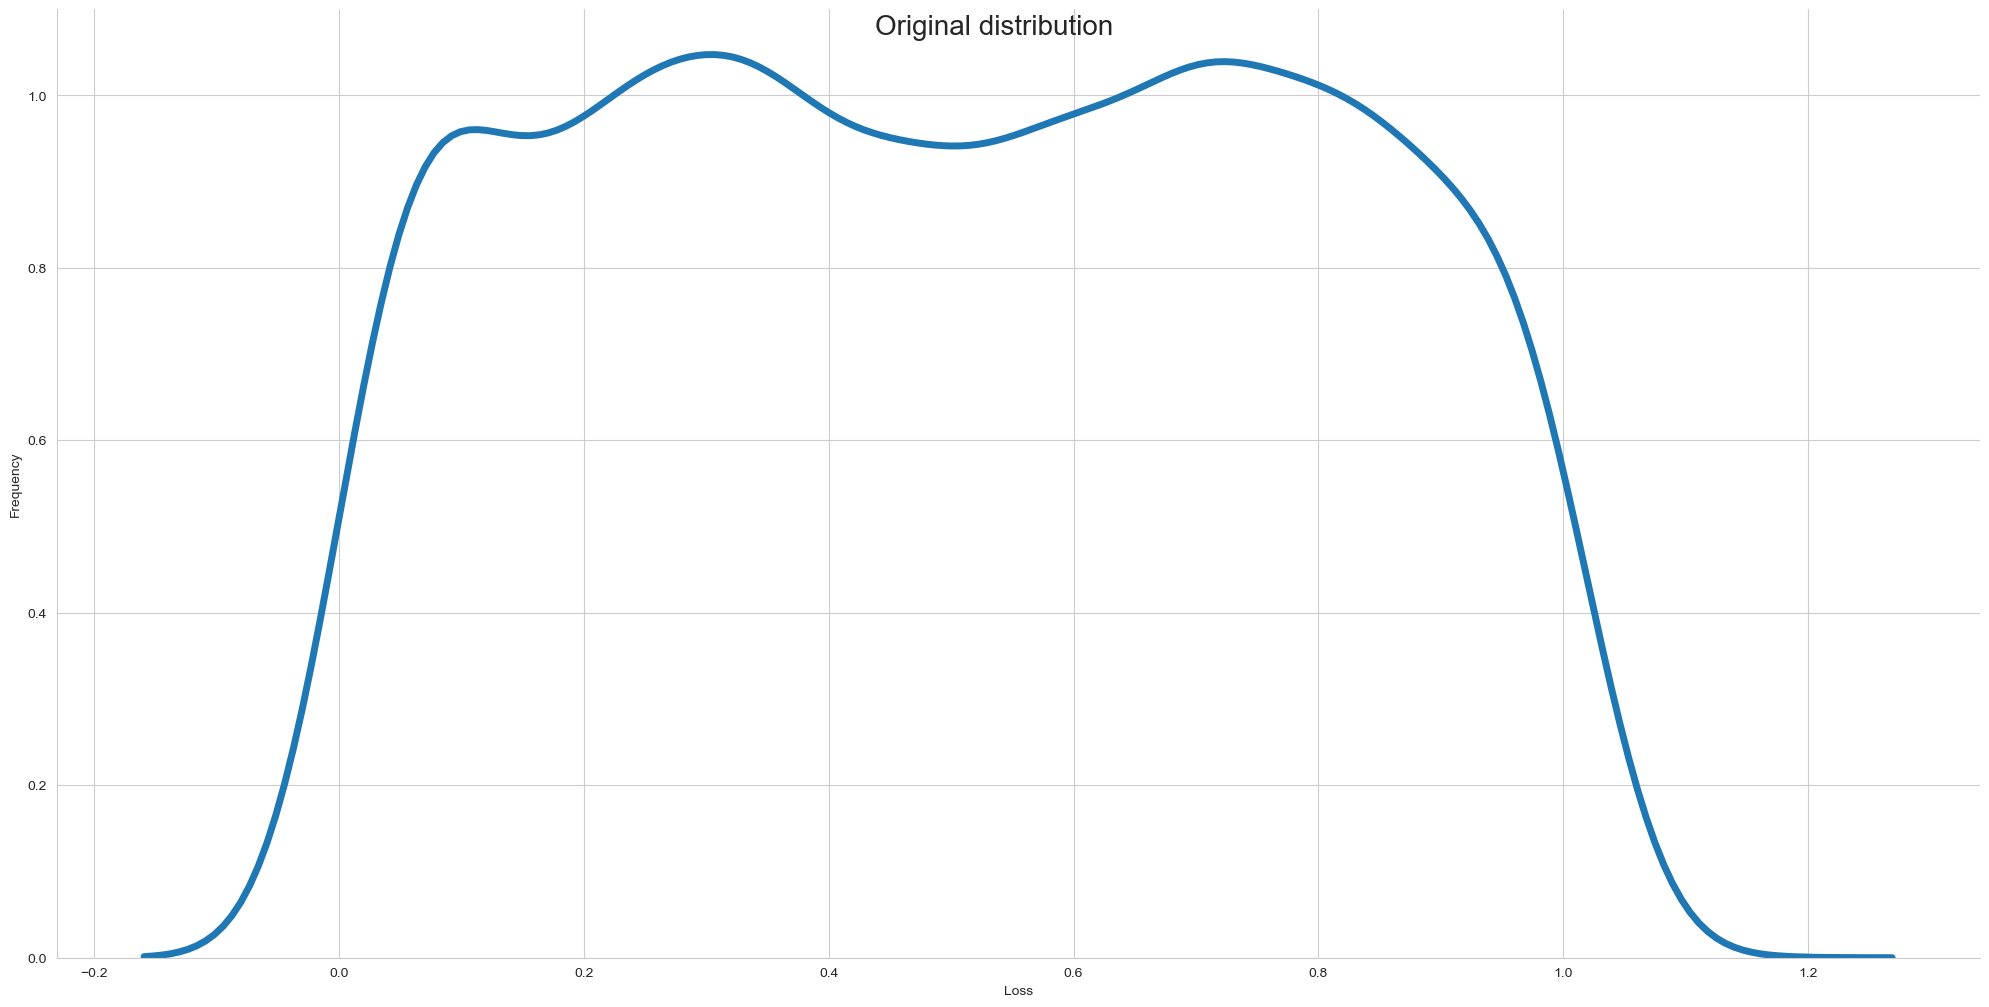

client_ 1  loss:  [5.38186167 5.22182463 5.06173239 ... 7.03056518 5.28241954 5.71072709] freq:  [ 23  45  67  89 111 133 155 177 199 221]
Shape: 0.9928122015208589
Location: 5.000048750372071
Scale: 1.0107665329189839


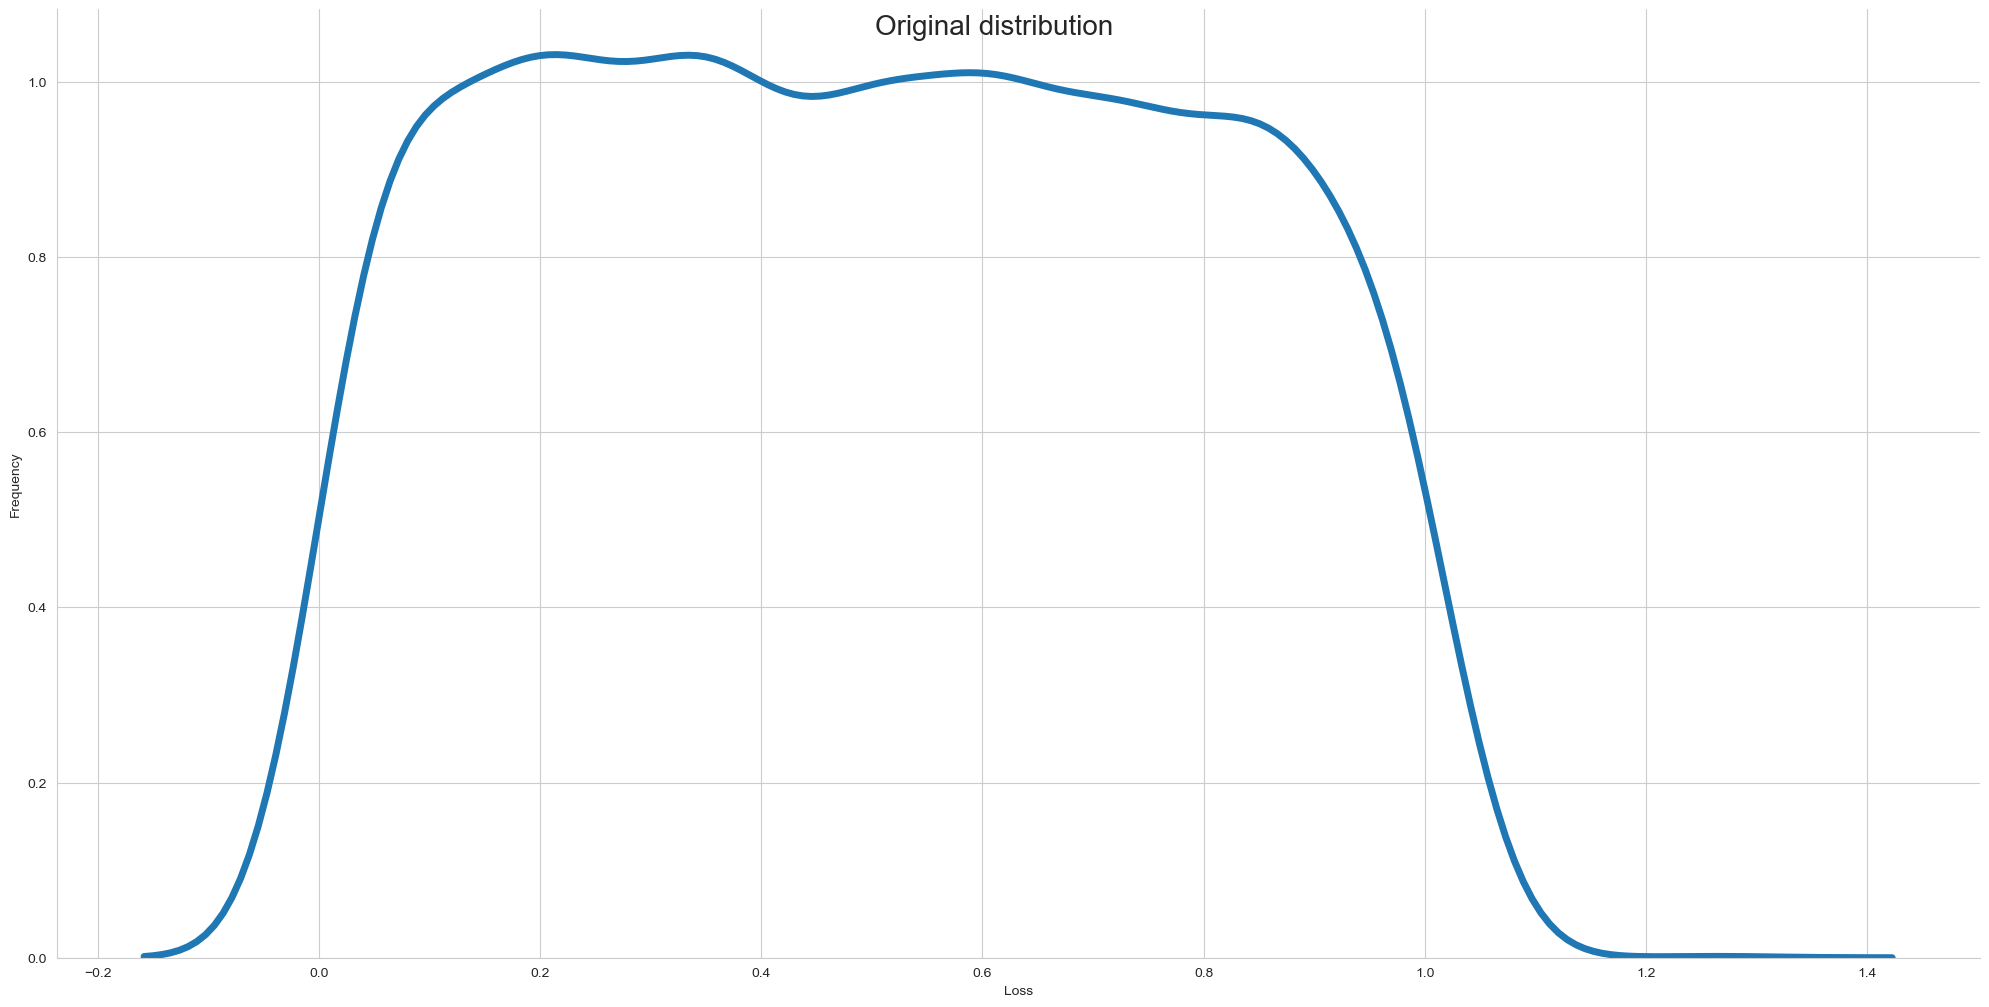

client_ 2  loss:  [5.68906994 5.41188036 5.40914787 ... 5.31310971 5.6879521  6.3040287 ] freq:  [ 24  48  72  96 120 144 168 192 216 240]
Shape: 0.8617996804330195
Location: 5.000097563632205
Scale: 0.8685630472773345


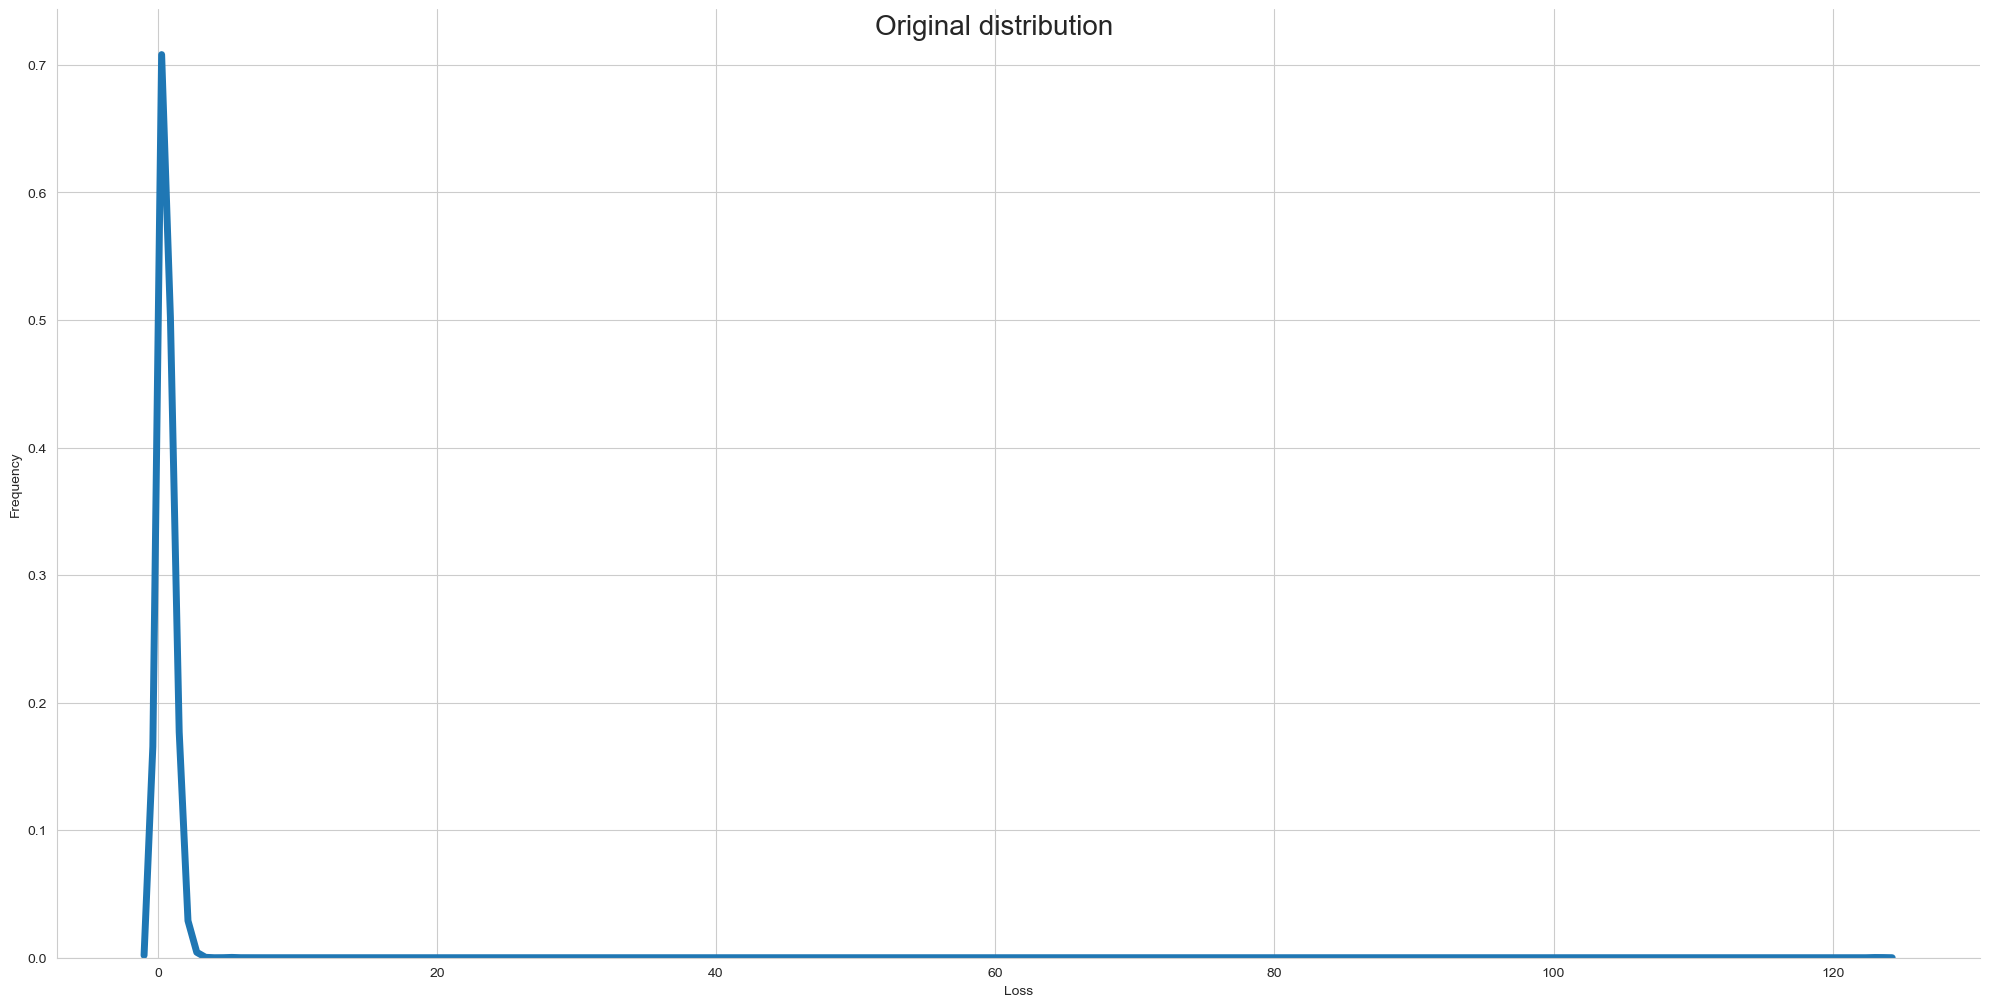

client_ 3  loss:  [5.23246492 6.99159893 5.43421953 ... 6.58339155 6.05668364 5.88806893] freq:  [ 24  48  72  96 120 144 168 192 216 240]
Shape: 1.0059448356451215
Location: 5.000109640932758
Scale: 1.0080638757433165


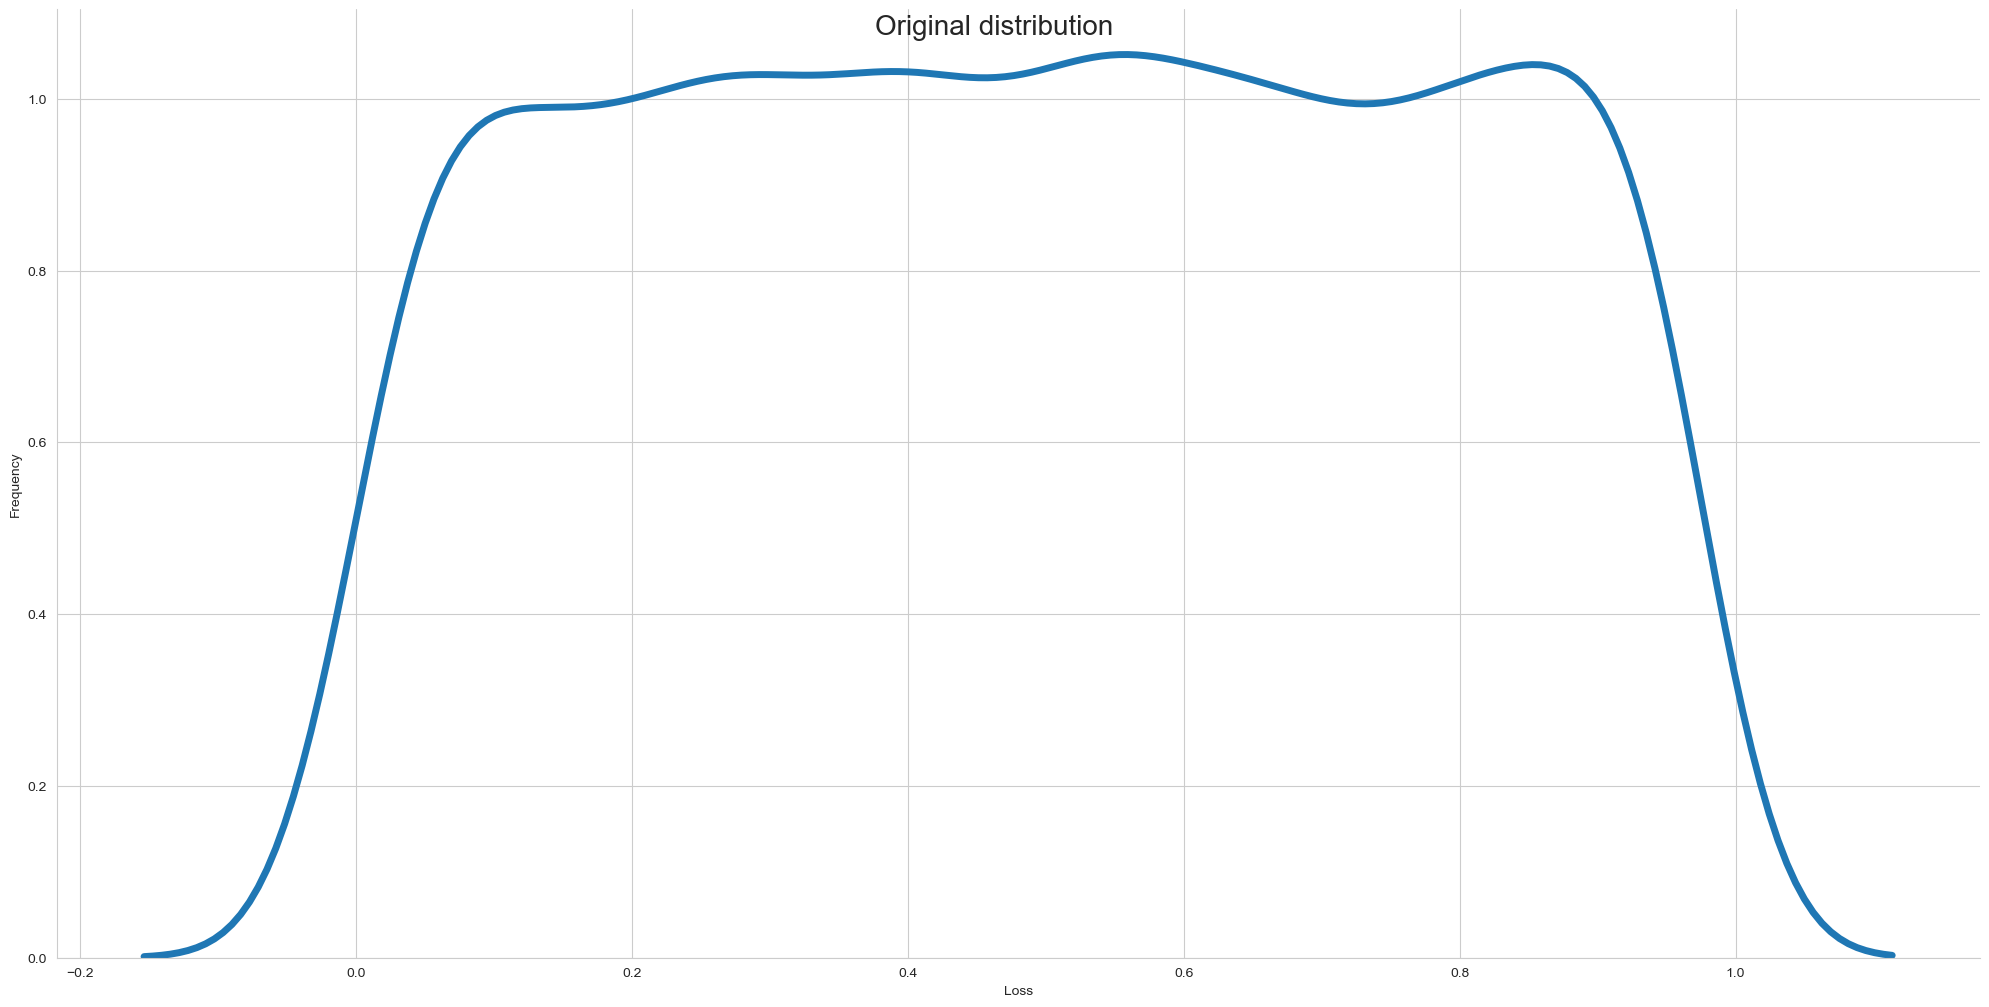

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 


for i in list(client_loss.keys()):
    if(i== len(list(client_loss.keys()))-1):
        continue
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])

    shape, loc, scale = stats.gamma.fit(client_loss[i])
    
    # Printing the estimated parameters
    print("Shape:", shape)
    print("Location:", loc)
    print("Scale:", scale)
    pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)
    sns.set_style("whitegrid")

    ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
                linewidth = 5 )
    ax.fig.suptitle('Original distribution', size = 20)
    plt.ylabel("Frequency")
    plt.xlabel("Loss")
    plt.show()

client_ 0  loss:  [5.93865416 5.13758057 5.17266814 ... 7.34843944 6.53012386 5.02555234] freq:  [ 59 117 175 233 291 349 407 465 524 582]


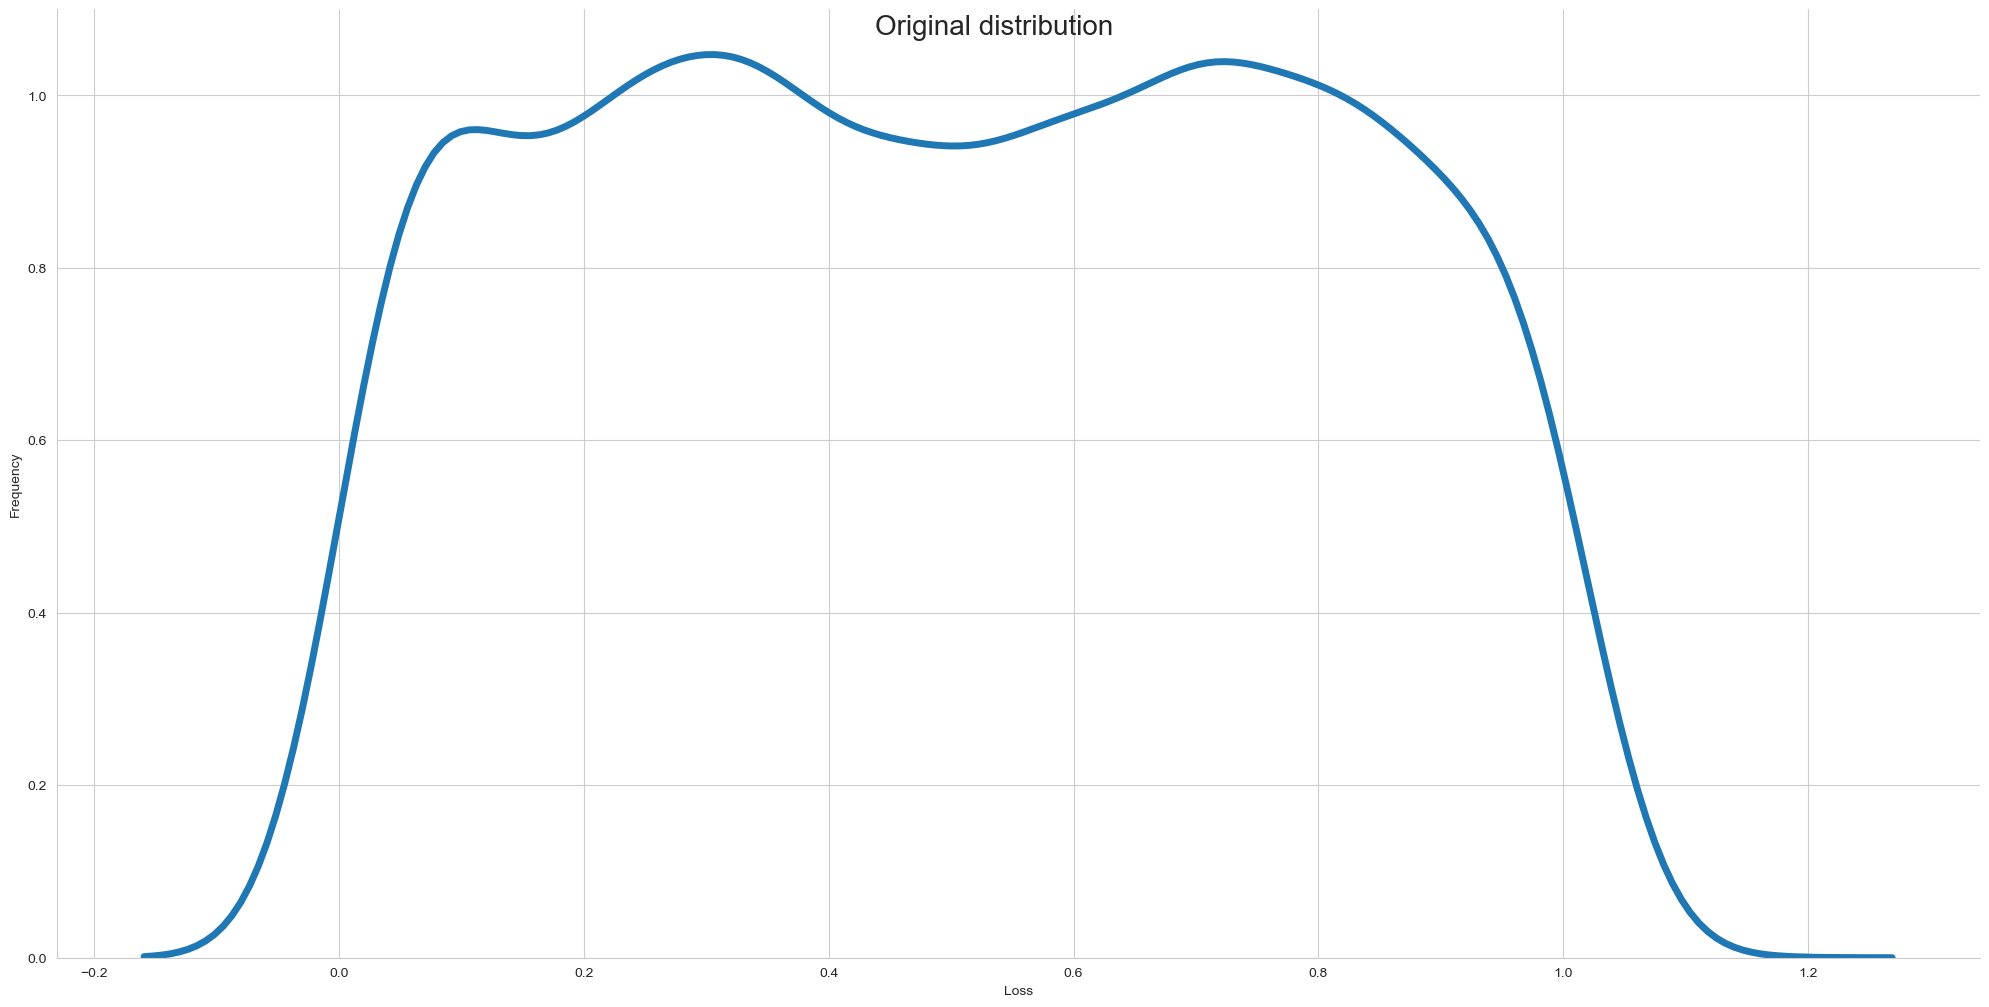

client_ 1  loss:  [5.38186167 5.22182463 5.06173239 ... 7.03056518 5.28241954 5.71072709] freq:  [ 23  45  67  89 111 133 155 177 199 221]


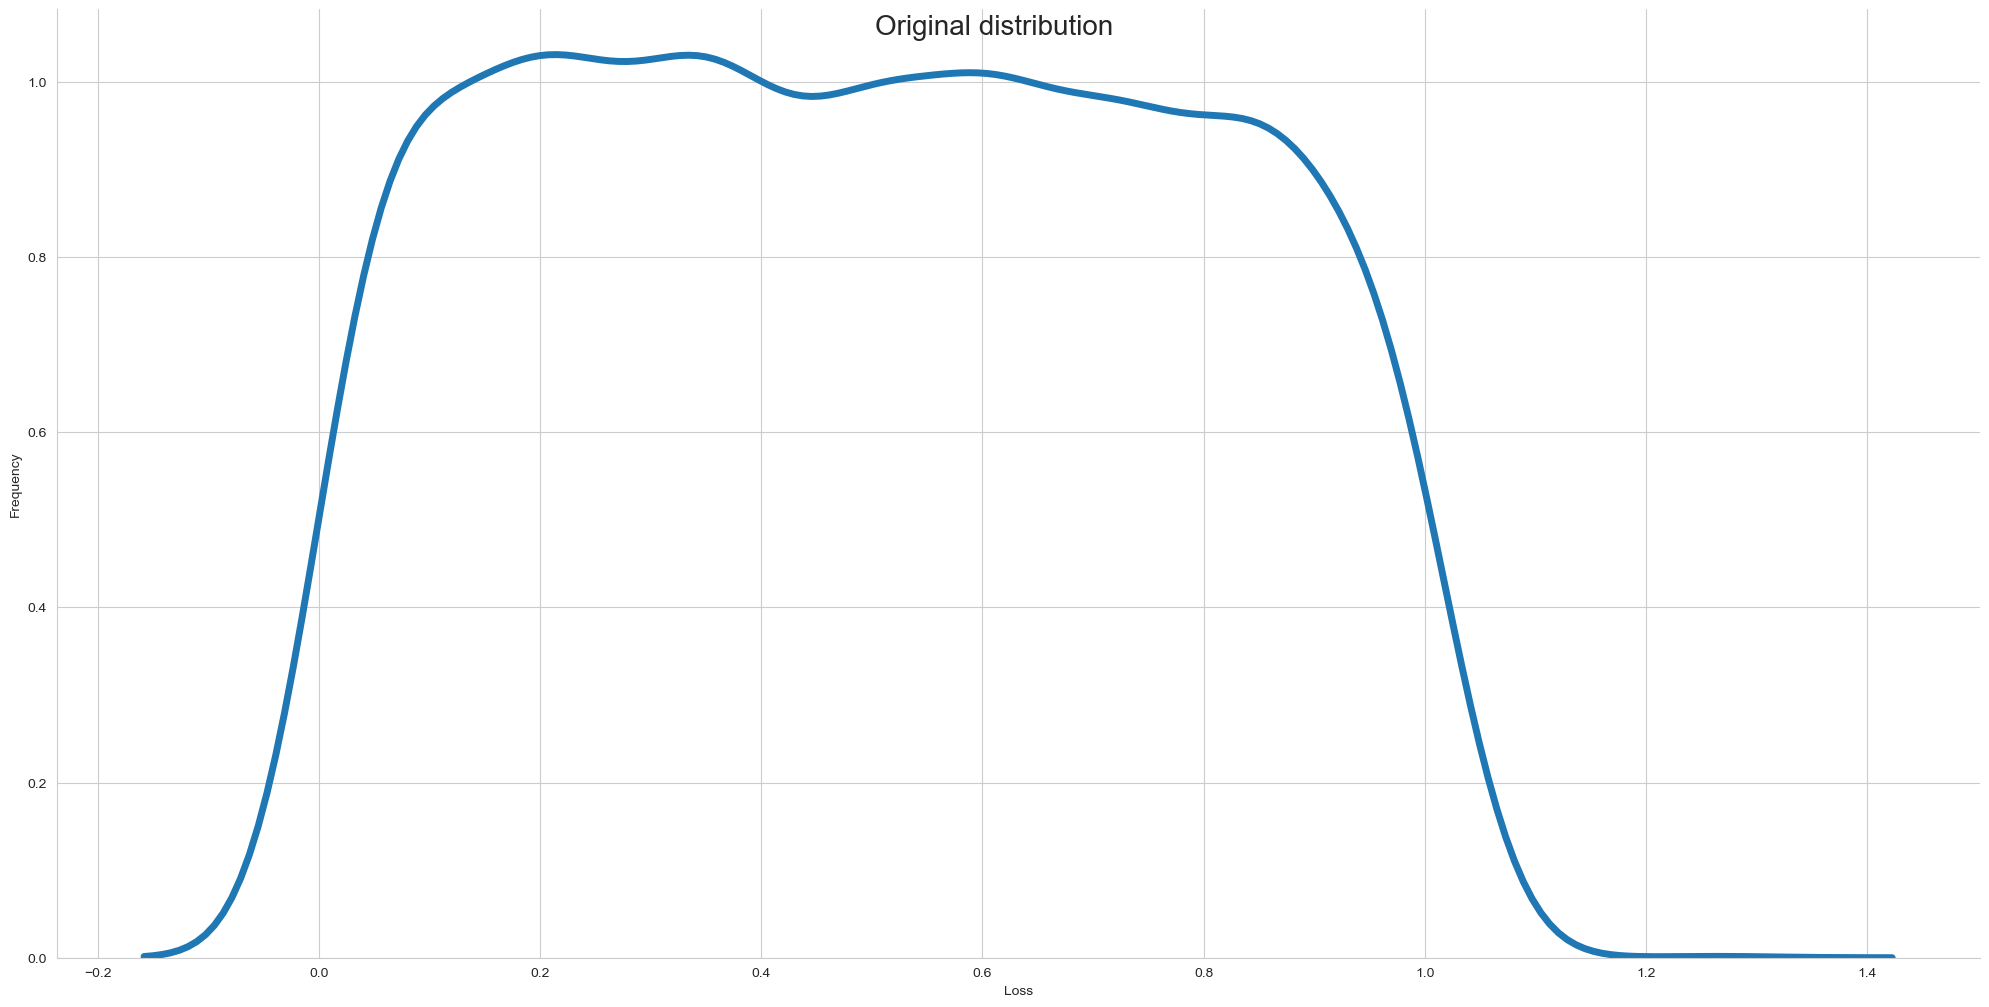

client_ 2  loss:  [5.68906994 5.41188036 5.40914787 ... 5.31310971 5.6879521  6.3040287 ] freq:  [ 24  48  72  96 120 144 168 192 216 240]


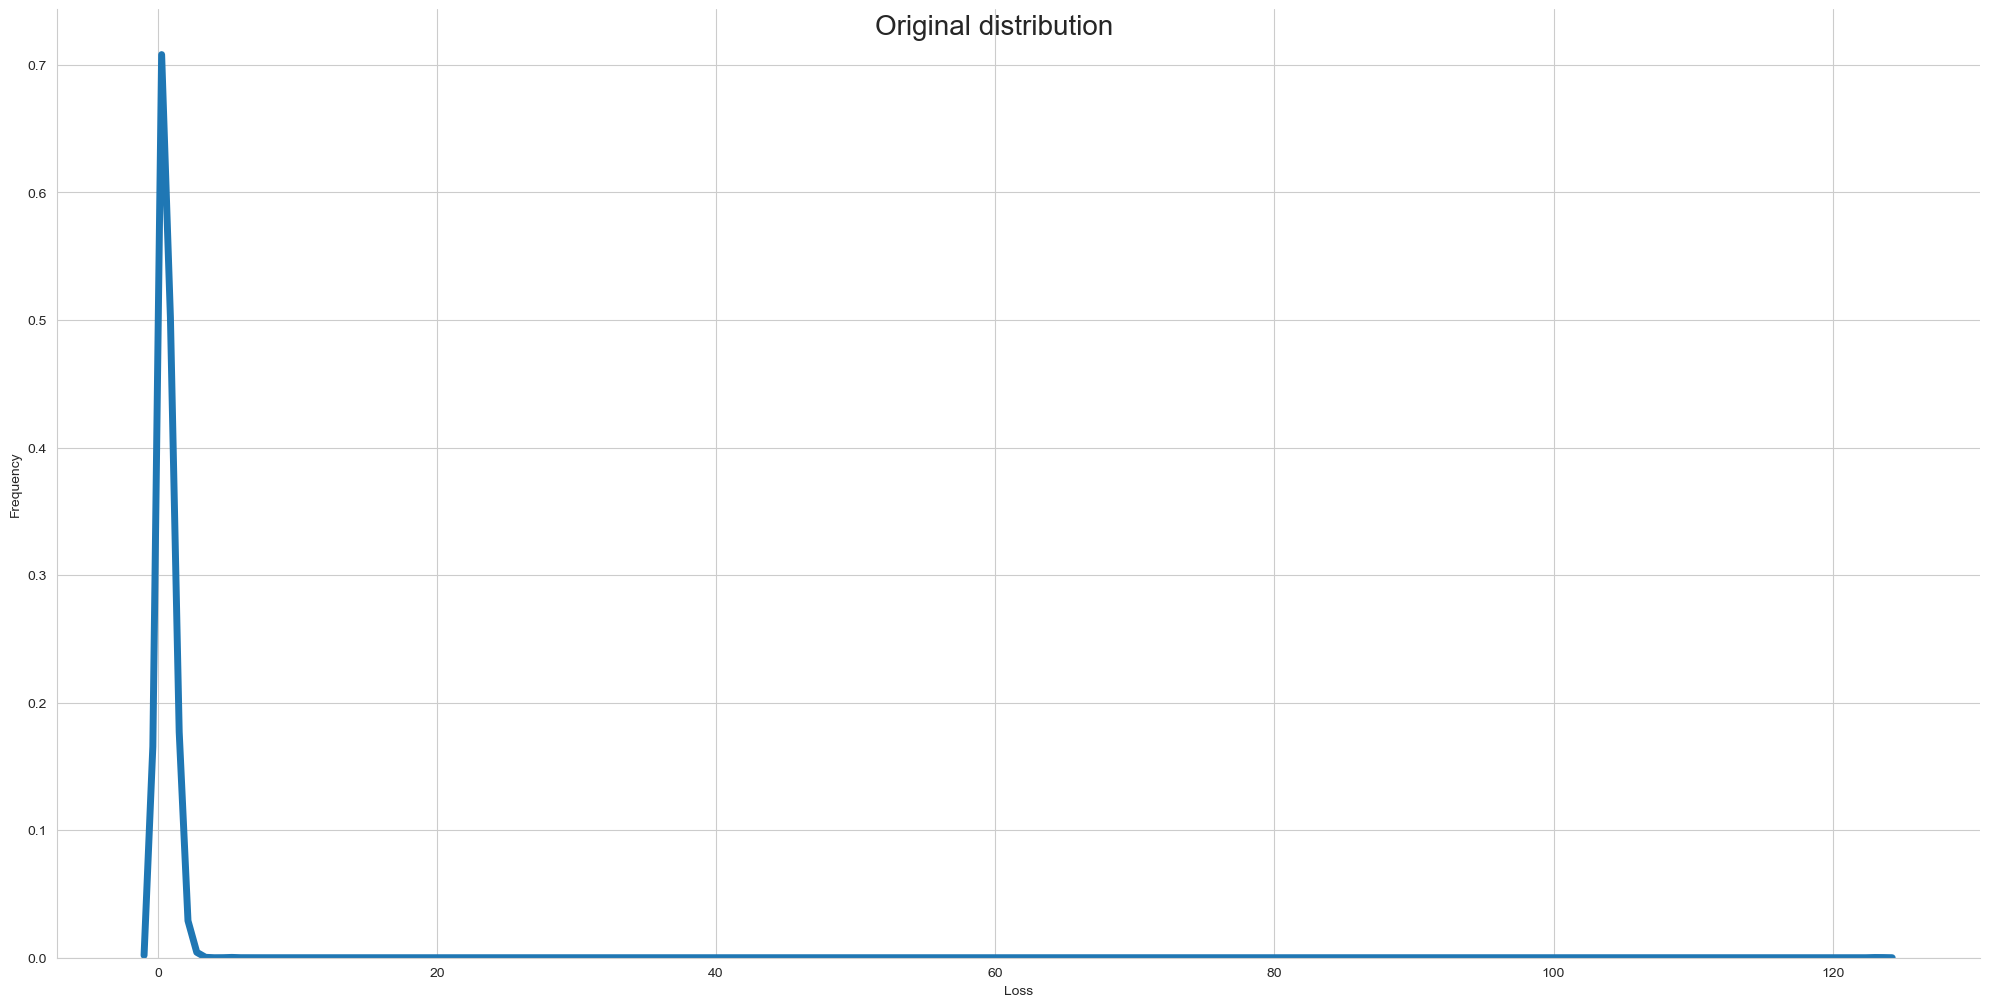

client_ 3  loss:  [5.23246492 6.99159893 5.43421953 ... 6.58339155 6.05668364 5.88806893] freq:  [ 24  48  72  96 120 144 168 192 216 240]


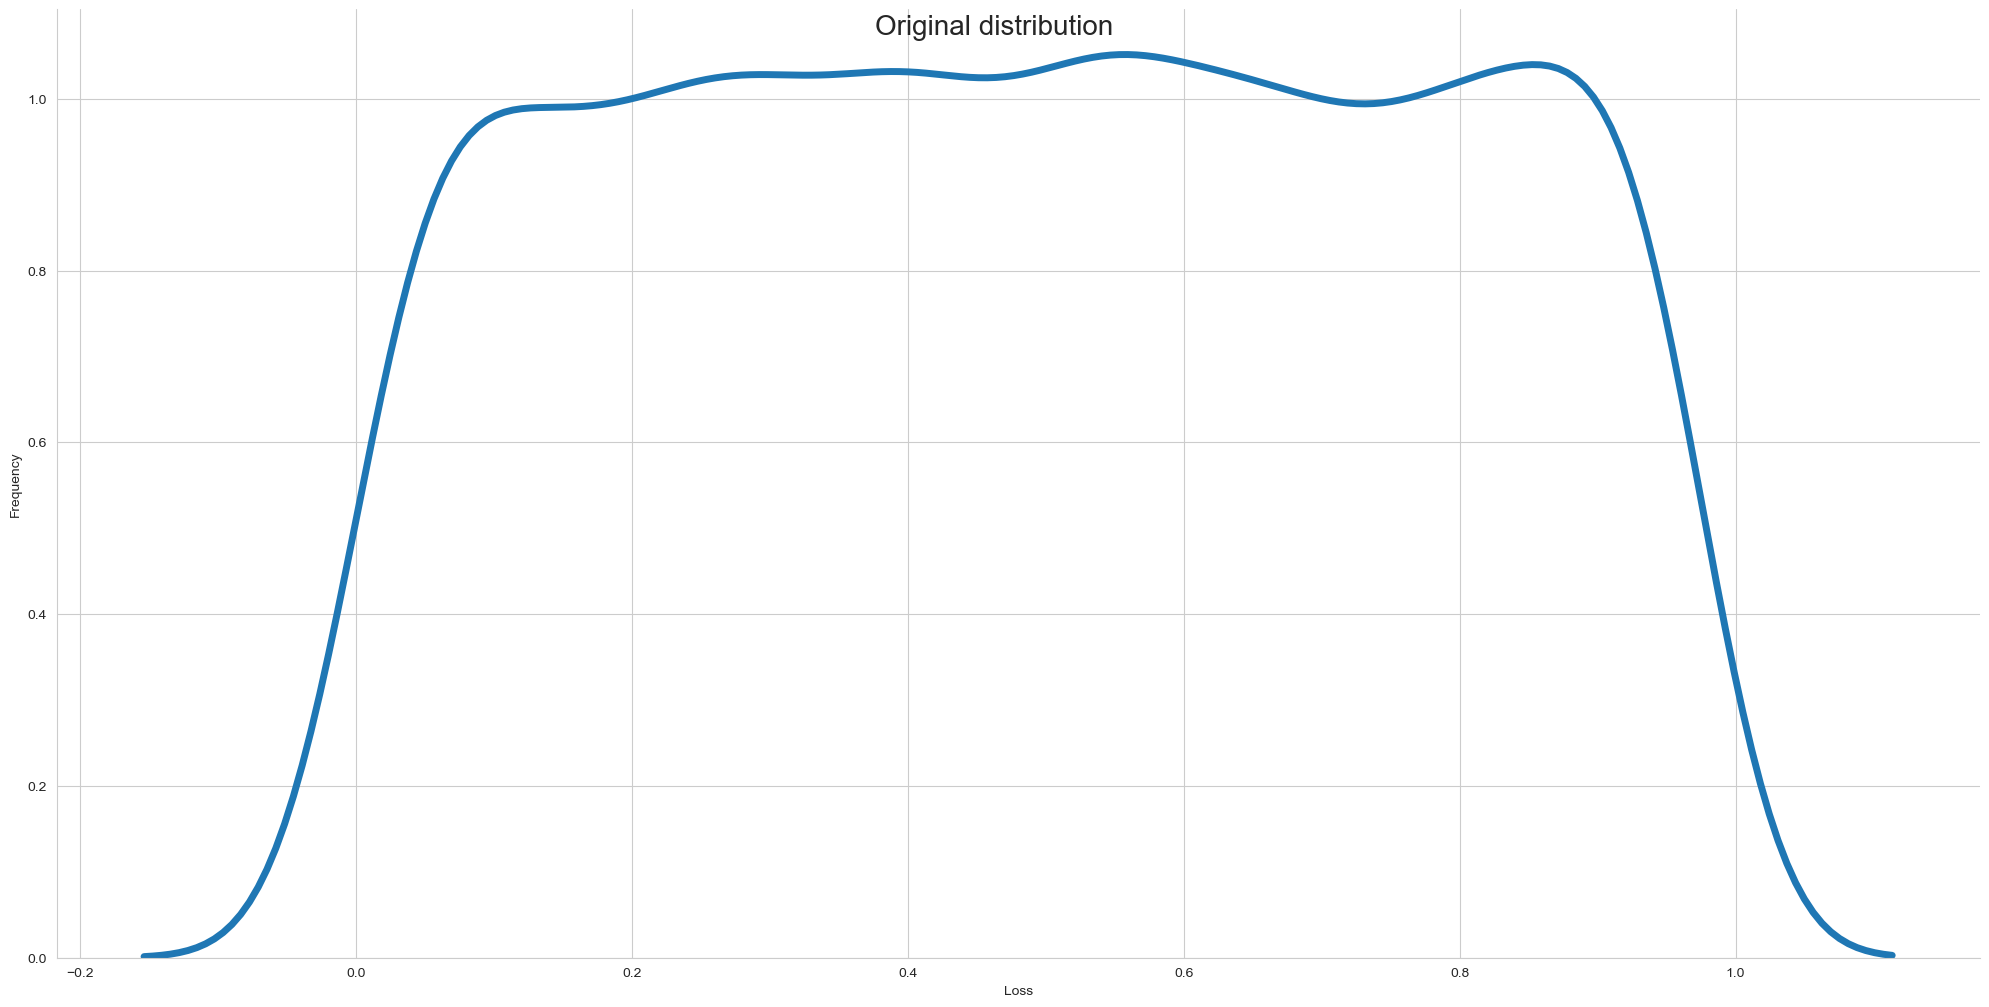

In [33]:
# experiment plotter

for i in list(client_loss.keys()):
    if(i== len(list(client_loss.keys()))-1):
        continue
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])
    
#     df_mean = np.mean(client_loss[i])
#     df_std = np.std(client_loss[i])
#     pdf = stats.norm.pdf(client_loss[i], df_mean, df_std)

    shape, loc, scale = stats.gamma.fit(client_loss[i])
    
    # Printing the estimated parameters
#     print("Shape:", shape)
#     print("Location:", loc)
#     print("Scale:", scale)
    pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)

#     plt.plot(client_loss[i], pdf, "-o", label = i)

#     client_loss[i] = stats.gamma.rvs(1, size=5000)+5
    sns.set_style("whitegrid")

    ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
                linewidth = 5 )
    ax.fig.suptitle('Original distribution', size = 20)
#     plt.plot(client_loss[i], client_frequency[i], "-o", label = i)
#     plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("Loss")
    plt.show()

In [20]:
score = global_model.evaluate(X_test, y_test, verbose=0)
score

[1.3119407892227173, 0.3776617646217346]

In [21]:
nn_preds = global_model.predict(X_test)
nn_preds = (nn_preds > 0.5)

nn_precision =precision_score(y_test, nn_preds)
nn_recall = recall_score(y_test, nn_preds)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_f1 = f1_score(y_test, nn_preds)


print("Precision = {}".format(nn_precision))
print("Recall = {}".format(nn_recall))
print("Accuracy = {}".format(nn_accuracy))
print("f1 = {}".format(nn_f1))


Precision = 0.24084644299039398
Recall = 0.734295415959253
Accuracy = 0.37766175266175267
f1 = 0.3627214592724604


In [22]:
arr = nn_preds > 0.5

unique, counts = np.unique(arr, return_counts=True)

np.asarray((unique, counts)).T

array([[   0, 2585],
       [   1, 7183]], dtype=int64)

In [23]:
# pdf for client losses
# x-loss
# y- frequency
# each client has one pdf for all rounds
# using histogram


# drop client
# non iid
# fedavg


# gender dist
# kernel density